# H&M数据特征工程实战

## H&M数据集介绍

**数据集描述**

对于这个挑战，你将获得顾客在一段时间内的购买历史记录，以及相关的元数据。你的任务是预测在训练数据结束后的7天内，每个顾客将购买哪些商品。在这段时间内没有进行任何购买的顾客将被排除在评分之外。

**文件**

- `images/`：包含与每个商品ID对应的图片的文件夹；图片被放置在以商品ID的前三位数字命名的子文件夹中；请注意，并非所有的商品ID值都有对应的图片。

- `articles.csv`：每个可购买商品ID的详细元数据。

- `customers.csv`：数据集中每个顾客ID的元数据。

- `transactions_train.csv`：训练数据，包括每个日期每个顾客的购买记录，以及额外的信息。重复的行表示同一商品的多次购买。你的任务是预测在训练数据期间结束后的7天内，每个顾客将购买哪些商品。

**数据来源**

来自于Kaggle比赛:[H&M Personalized Fashion Recommendations](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from tqdm import tqdm

# 设置要显示的行数和列数
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

plt.rcParams['font.sans-serif'] = ['SimHei']   #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False   #用来正常显示负号

In [5]:
article_df = pd.read_csv("../matplotlib/articles.csv")
customer_df = pd.read_csv("../matplotlib/customers.csv")
transaction_df = pd.read_csv("../matplotlib/transactions_train.csv").sample(n=100000).reset_index(drop=True)

### Articles数据

这个表格包含了所有H&M的商品，包括产品类型、颜色、产品组和其他特征的详细信息。

商品数据描述：

- `article_id`：每个商品的唯一标识符。
- `product_code`、`prod_name`：每个产品及其名称的唯一标识符（不同）。
- `product_type`、`product_type_name`：`product_code`及其名称的产品组。
- `graphical_appearance_no`、`graphical_appearance_name`：图形及其名称的组别。
- `colour_group_code`、`colour_group_name`：颜色及其名称的组别。
- `perceived_colour_value_id`、`perceived_colour_value_name`、`perceived_colour_master_id`、`perceived_colour_master_name`：附加的颜色信息。
- `department_no`、`department_name`：每个部门及其名称的唯一标识符。
- `index_code`、`index_name`：每个指标及其名称的唯一标识符。
- `index_group_no`、`index_group_name`：一组指标及其名称。
- `section_no`、`section_name`：每个部分及其名称的唯一标识符。
- `garment_group_no`、`garment_group_name`：每个服装及其名称的唯一标识符。
- `detail_desc`：详细描述。描述是关于H&M商品的数据集。

### Customers数据

- `customer_id`：每位客户的唯一标识符
- `FN`：1 或 缺失
- `Active`：1 或 缺失
- `club_member_status`：会员俱乐部状态
- `fashion_news_frequency`：H&M 可以向客户发送新闻的频率
- `age`：当前年龄
- `postal_code`：客户的邮政编码

### Transactions 数据

- `t_dat`：日期
- `customer_id`：每位客户的唯一标识符（在客户表中）
- `article_id`：每个商品的唯一标识符（在商品表中）
- `price`：购买价格
- `sales_channel_id`：销售渠道的标识符（1 或 2）

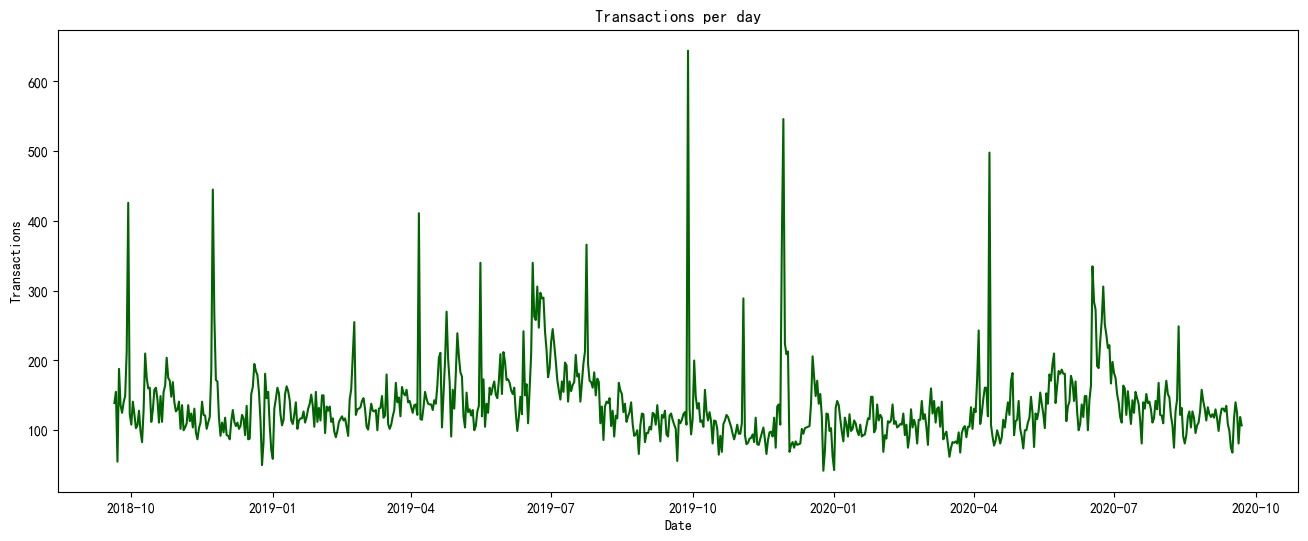

In [19]:
# 计算每天的订单笔数
df = transaction_df.groupby(["t_dat"])["price"].count().reset_index()
df["t_dat"] = df["t_dat"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df.columns = ["Date", "Transactions"]
fig, ax = plt.subplots(1, 1, figsize=(16,6))
ax.plot(df["Date"], df["Transactions"], color="Darkgreen")
ax.set_xlabel("Date")
ax.set_ylabel("Transactions")
plt.title(f"Transactions per day")
plt.show()

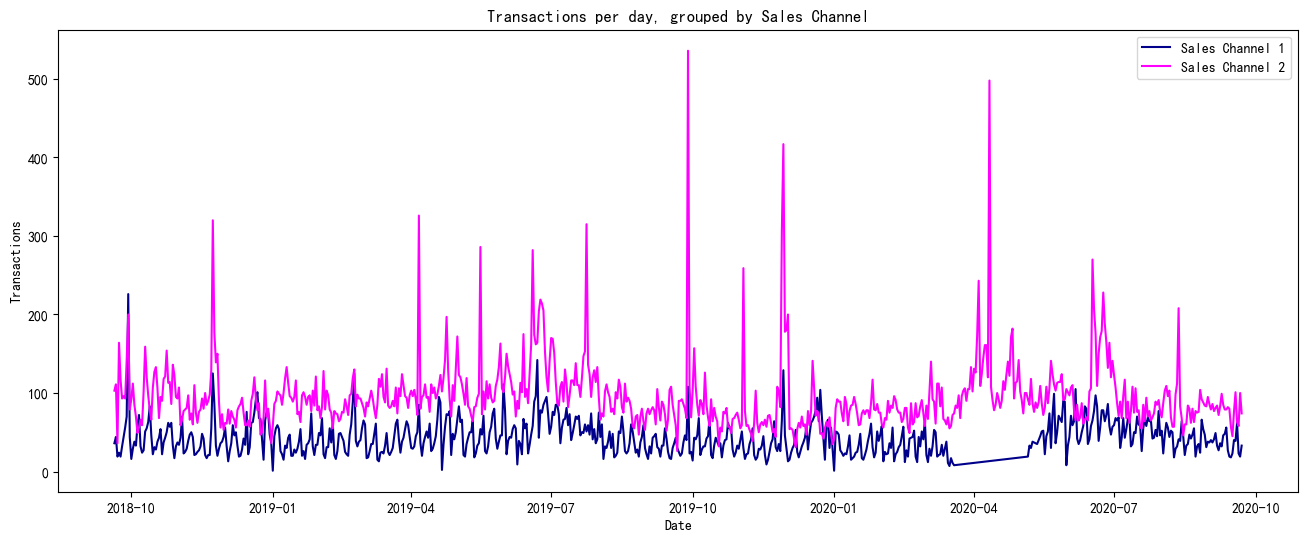

In [20]:
# 计算每天不同渠道的订单笔数
df = transaction_df.groupby(["t_dat", "sales_channel_id"])["article_id"].count().reset_index()
df["t_dat"] = df["t_dat"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df.columns = ["Date", "Sales Channel Id", "Transactions"]
fig, ax = plt.subplots(1, 1, figsize=(16,6))
g1 = ax.plot(df.loc[df["Sales Channel Id"]==1, "Date"], df.loc[df["Sales Channel Id"]==1, "Transactions"], label="Sales Channel 1", color="Darkblue")
g2 = ax.plot(df.loc[df["Sales Channel Id"]==2, "Date"], df.loc[df["Sales Channel Id"]==2, "Transactions"], label="Sales Channel 2", color="Magenta")
plt.xlabel("Date")
plt.ylabel("Transactions")
ax.legend()
plt.title(f"Transactions per day, grouped by Sales Channel")
plt.show()

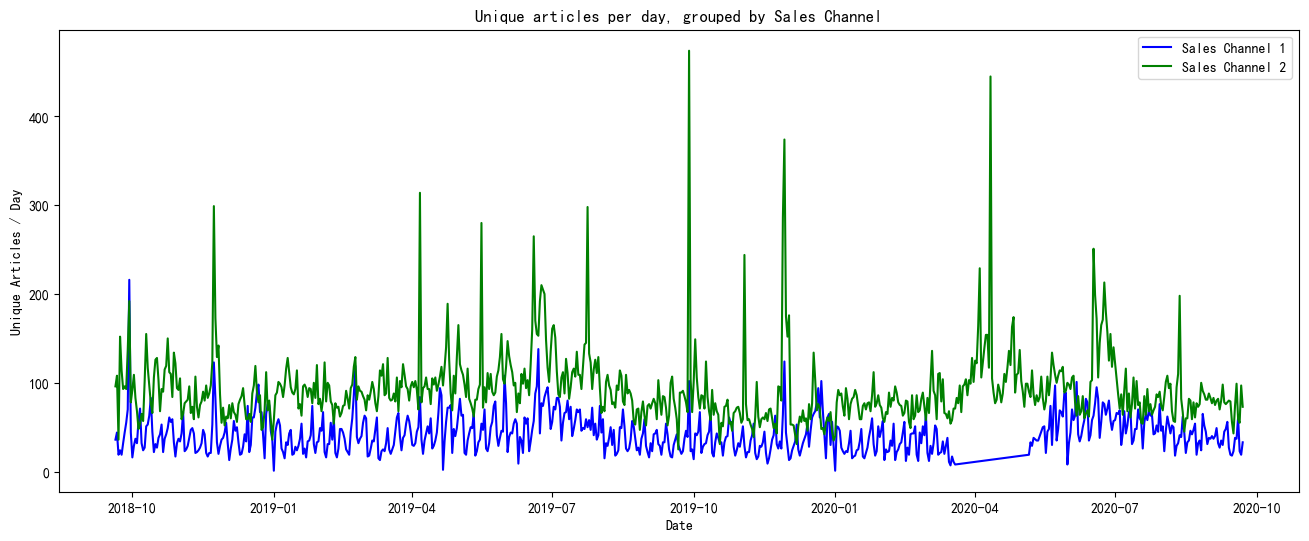

In [21]:
# 统计了每天不同渠道下的商品的unique值
df = transaction_df.groupby(["t_dat", "sales_channel_id"])["article_id"].nunique().reset_index()
df["t_dat"] = df["t_dat"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df.columns = ["Date", "Sales Channel Id", "Unique Articles"]
fig, ax = plt.subplots(1, 1, figsize=(16,6))
g1 = ax.plot(df.loc[df["Sales Channel Id"]==1, "Date"], df.loc[df["Sales Channel Id"]==1, "Unique Articles"], label="Sales Channel 1", color="Blue")
g2 = ax.plot(df.loc[df["Sales Channel Id"]==2, "Date"], df.loc[df["Sales Channel Id"]==2, "Unique Articles"], label="Sales Channel 2", color="Green")
plt.xlabel("Date")
plt.ylabel("Unique Articles / Day")
ax.legend()
plt.title(f"Unique articles per day, grouped by Sales Channel")
plt.show()

## 特征工程

特征工程在机器学习中占据核心地位，它涉及从原始数据中提取有价值的信息，以优化和提高模型的性能。本教程旨在深入探讨特征工程的基础理论和实践应用。

### 特征工程的重要性

特征工程是构建机器学习模型过程中的关键步骤。优质的特征不仅可以显著提高模型的性能，还能减少所需的数据量，从而在处理复杂数据时提高效率和准确性。

### 特征工程的一般做法

在进行特征工程时，首先需要识别并分类数据特征的类型。主要类型包括连续特征、离散特征、序列特征和多模态特征。本教程将主要聚焦于连续特征和离散特征的处理方法。

#### 连续特征的特征工程

连续特征通常是数值型的，可以在任意两个值之间取无数个数值。常见的连续特征处理方法包括：

- **特征间的二元数学运算**：例如，通过特征的加、减、乘、除来创建新的特征。例如，若有特征表示房屋的宽度和长度，可以通过它们的乘积来创建一个表示面积的新特征。
- **单个特征的处理**：
  - **标准化**：调整特征数据，使其均值为0，标准差为1，有助于加速学习算法的收敛。
  - **归一化**：将特征缩放到给定的最小值和最大值之间，常用于将特征值限制在0和1之间。
  - **其他数学变换**：如对数变换，有助于处理偏态分布的数据。
  - **离散化**：将连续特征分割成若干区间，转换为离散特征。常见的方法包括等频（每个区间含有相同数量的点）和等距（每个区间长度相同）。

#### 离散特征的特征工程

离散特征通常是分类的，表示为一组有限的类别。处理离散特征的常用方法包括：

- **特征对的处理**：
  - **特征交叉**：结合两个或多个特征创建新特征，例如，结合“城市”和“职业”特征来预测收入。
  - **Group特征**：根据一个或多个特征进行分组，然后对每组进行汇总统计，如计算平均值、最大值或计数。
- **单个特征的处理**：
  - **标签编码（Label Encoding）**：将类别标签转换为序列数字。
  - **独热编码（One-Hot Encoding）**：为每个类别创建一个新的二进制特征。
  - **目标编码（Target Encoding）**：基于目标变量的平均值对类别进行编码。
  - **计数编码（Count Encoding）**：基于每个类别出现的频率进行编码。

### 特征工程实践

In [33]:
# 合并数据
df = transaction_df.merge(article_df,on='article_id',how='left')
df = df.merge(customer_df,on='customer_id',how='left')
print(df.shape)

(100000, 35)


#### 连续特征的特征工程实践

In [24]:
#连续特征  
def num_add(df,f1,f2):
    #add
    df[f'{f1}_add_{f2}'] = df[f1]+df[f2]
    return df

def num_mul(df,f1,f2):
    #mul
    df[f'{f1}_mul_{f2}'] = df[f1]*df[f2]
    return df

def num_div(df,f1,f2):
    #div
    df[f'{f1}_div_{f2}'] = df[f1]/(df[f2]+df[f2].mean())
    return df

def num_log(df,f):
    #log
    df[f'log_{f}'] = np.log(1+df[f])
    return df

def num_bin(df,f,num_bins=10,bin_type='cut'):
    #bin
    if bin_type=='cut': 
        df[f'{f}_bin_{num_bins}'] = pd.cut(df[f],num_bins,labels=False)
    else:
        df[f'{f}_bin_{num_bins}'] = pd.qcut(df[f],num_bins,labels=False)
    return df
    

In [25]:
df = num_bin(df,'age',10,bin_type='qcut')

#### 离散特征的特征工程实践

In [27]:
#离散变量特征工程
def one_hot_enc(df,f):
    #one-hot
    enc = OneHotEncoder()
    enc.fit(df[f].values.reshape(-1,1))
    one_hot_array=enc.transform(df[f].values.reshape(-1,1)).toarray()
    df[[f'{f}_one_hot_{i}' for i in range(4)]] = one_hot_array
    return df

def hash_enc(df,f_list,n_components=8):
    #hash enc
    ce_encoder = ce.HashingEncoder(cols = f_list,n_components=n_components).fit(df)
    df = ce_encoder.transform(df)
    df.rename(columns=zip([f'col_{i}' for i in range(n_components)],[f'hash_enc_{i}' for i in range(n_components)]))
    return df

def count_enc(df,f):
    #count enc
    map_dict = dict(zip(df[f].unique(), range(df[f].nunique())))
    df[f'label_enc_{f}'] = df[f].map(map_dict).fillna(-1).astype('int32')
    df[f'{f}_count'] = df[f].map(df[f].value_counts())
    return df

def cross_enc(df,f1,f2):
    #cross enc
    print('====================================== {} {} ======================================'.format(f1, f2))
    if f'{f1}_count' not in df.columns:
        df = count_enc(df,f1)
    if f'{f2}_count' not in df.columns:
        df = count_enc(df,f2)
    df[f'{f1}_{f2}'] = df[f1].astype('str')+'_'+df[f2].astype('str')
    df = count_enc(df,f'{f1}_{f2}')
    df[f'{f1}_{f2}_count_div_{f1}_count'] = df[f'{f1}_{f2}_count'] / (df[f'{f1}_count']+df[f'{f1}_count'].mean())
    df[f'{f1}_{f2}_count_div_{f2}_count'] = df[f'{f1}_{f2}_count'] / (df[f'{f2}_count']+df[f'{f2}_count'].mean())
    del df[f'{f1}_{f2}']
    return df
    
def group_stat(df,cat_fea,num_fea):
    for stat in tqdm(['min', 'max', 'mean', 'median', 'std', 'skew']):
        df[f'{cat_fea}_{num_fea}_groupby_{stat}'] = df.groupby(cat_fea)[num_fea].transform(stat)
    return df

In [28]:
# 离散特征编码
cate_fea_list = ['customer_id','article_id','sales_channel_id',
                 'product_code','section_no','postal_code']

In [29]:
# label enc & count enc
for col in tqdm(cate_fea_list):
    df = count_enc(df,col)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.60it/s]


In [30]:
# 交叉特征
df = cross_enc(df,'customer_id','article_id')
df = cross_enc(df,'customer_id','product_code')
df = cross_enc(df,'age','article_id')

====================================== customer_id article_id ======================================
====================================== customer_id product_code ======================================
====================================== age article_id ======================================


In [31]:
# group特征
df = group_stat(df,'customer_id','price')
df = group_stat(df,'age','price')

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 182.32it/s]


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 74 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   t_dat                                                  100000 non-null  object 
 1   customer_id                                            100000 non-null  object 
 2   article_id                                             100000 non-null  int64  
 3   price                                                  100000 non-null  float64
 4   sales_channel_id                                       100000 non-null  int64  
 5   product_code                                           100000 non-null  int64  
 6   prod_name                                              100000 non-null  object 
 7   product_type_no                                        100000 non-null  int64  
 8   product_type_name                  